In [ ]:
#######
# This cell is meant to install packages if some are missing
#######

# !pip install tqdm scipy
# !pip install matplotlib
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install --upgrade tdmclient

In [1]:

# import matplotlib.pyplot as plt
import time
from time import sleep
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
# from Motion_control import motors, get_turn, kalman_adjust
import Motion_control as mc

import aruco_vision as av
from djikstra import djikstra_algo
from calibration import calibration_mm

### Connect the thymio(the speed set to 0 is here in case of an error during calibration or during the code)
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 8686cf32-0aa4-410e-9c02-65fc7cdb6752

# Calibration

In this section, we will run multiple functions, in order to calibrate our thymio to the current environement. This gives us more flexibility, and makes it easier to use different thymio in different environment.

### Calibration of the thymio 

In this first step, we will use the following image to calibrate the speed, its conversion ratio from the thymio's sensor to mm/s, and its variance for the Kalman filter.
<!-- ![localisation map](Pictures/Picture3.jpg) -->
<img src="Pictures/Picture1.jpg" width="900"/>

In this next function, we will ask the thymio to move forward, at a known speed. As soon as its ground sensor detect it is on the black line, it will start a timer. When it exit the line, the timer will stop, the thymio will stop aswell, and all the desired values will be computed. In this function, the line length is know and we need to be careful to properly align the thymio as to make it follow the line. We can also adjust the speed to make it go as straight as possible, and adjust the transition threshold if the ligth's intensity in the current room requires it.

In [2]:

thymio_data = []
SPEED = 100
Ts = 0.01
TRANSITION_THRESHOLD = 400
LINE_LENGTH = 300


speed_conversion = 0
q_nu = 0


q_nu, speed_conversion = calibration_mm(node, Ts, thymio_data, LINE_LENGTH, TRANSITION_THRESHOLD, q_nu, speed_conversion, client, SPEED)



The conversion factor for the speed of the thymio to mm/sh is : 0.312545077857503 
With a desired speed of : 100, the thymio speed is : 31.254507785750302 mm/s
The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : 2.648754601708732 


### Calibration of the camera
In this next cell, we will retrieve the the grid from the camera, and do all the conversion requiered for the rest of the project. This is done here, because we need to calibrate the image aswell, according to the position of the webcam. This function will make a conversion ratio between the image size and the known size of our grid.

In [3]:
# r_nu = 3.0764448059666183 
# speed_conversion = 0.3223689216457424 
# Ts = 0.01
# SPEED = 100
vision = av.Vision()
q_nu = 1
r_p_cam = 1 # a enlever une fois calculé
q_p_cam = 1 # a enlever une fois calculé
Q_cam = np.array([q_nu, q_p_cam])
R_cam = np.array([q_nu, r_p_cam])

In [4]:
# Ici on pourrait éventuellement calculer la taille de chaque case, et faire une variance pour kalman
print(vision.grid)


[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Run code

Now that we have everything set up, we can run the code

In [ ]:
#######
# The following values have been set in the calibration part
# 
# Ts = 0.01
# Speed = 60
# TRANSITION_THRESHOLD = 400
# If a preview is needed, run the following command
#
# print(f" The sampling time is : {Ts} s \n The speed is : {SPEED} mm/s \n The transition threshold is : {TRANSITION_THRESHOLD} \n")¨
# 
#######
#  The following values are the results of the calibration part 
#
# q_nu 
# r_nu
# conversion
# 
# print(f"The conversion factor for the speed of the thymio in mm/s is : {conversion} ")
# print(f"The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : {std_speed} ")
#######


[[7 6 5 4 3 3]
 [2 2 2 2 2 3]]


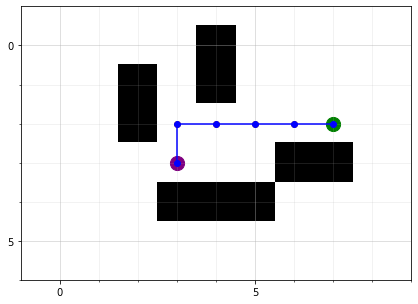

In [5]:
#same values as in the exercise session
r_p_gnd = 0.25 
q_p_gnd = 0.04

# Q_gnd = np.array([q_nu, q_p_gnd])
# R_gnd = np.array([q_nu, r_p_gnd])
vision.update_coordinates()# KF = KalmanFilter(Ts, vision.thymio_position, speed_conversion, Q_cam, Q_gnd, R_cam, R_gnd)  # we initialize the filter

shortest_path = djikstra_algo(vision.grid.T, vision.thymio_position, vision.goal_position)
print(shortest_path)


In [6]:
print(f" goal position is : {vision.goal_position}")
print(f" thymio's position is : {vision.thymio_position}")

 goal position is : (3, 3)
 thymio's position is : (7, 2)


In [7]:
SPEED = 100
r_p_gnd = 0.25 
q_p_gnd = 0.04
orientation = mc.correct_orientation(vision.thymio_orientation)
x = vision.thymio_position[0]
y = vision.thymio_position[1]

jump = False
jump_x,jump_y = 0,0
turn_speed = 0
kalmann_pos_x, kalmann_pos_y = 0,0
ajdust = 0
for dx,dy in np.transpose(shortest_path):
    if jump:
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        if jump_x == dx and jump_y == dy:
            jump = False
        continue
    
    # vision.update_coordinates()  #camera_check()
    # angle = vision.thymio_orientation #angle of the robot
    # if angle>=0:
    #     adjust_angle = angle - orientation*90
    # else:
    #     adjust_angle = angle - orientation*90 +360
    # motors(node,-SPEED*np.sign(adjust_angle), SPEED*np.sign(adjust_angle))
    # time.sleep(5*abs(adjust_angle)//180)
    # motors(node,0, 0)
    if False :#local_nav_error()
        jump_x,jump_y = 0,0#local_nav_correct(x,y,shortest_path)
    else:
        
        #compute du temps de parcours : duree = dist / (SPEED * speed_conversion )
        # check avec start = time.time() puis time.time() - start = dureee
        turn = mc.get_turn(dx-x,dy-y,orientation)
        orientation = orientation + turn
        turn_speed = int(SPEED*np.sign(turn))
        mc.motors(node,-(turn_speed-1), turn_speed)
        print("turn", turn_speed)
        await client.sleep(5*abs(turn)//2)
        if (((dx-x)!=0) | ((dy-y)!=0)):
            kalman_pos_x,kalman_pos_y= 125*dx,125*dy #KF.filter(isCamOn, pos_from_cam, orientation, 100, gnd, gnd_prev, transition_threshold)
            adjust_turn,adjust_speed = mc.kalman_adjust(dx,dy,kalman_pos_x,kalman_pos_y,orientation)
            kalman_pos_x = int(SPEED - adjust_turn - adjust_speed) #je reutilise juste les variables
            kalman_pos_y = int(SPEED + adjust_turn - adjust_speed)
            mc.motors(node,kalman_pos_x+1, kalman_pos_y)
            await client.sleep(3.5)
            mc.motors(node,0, 0)
    x = dx      #actualize the coordinates of the robot
    y = dy      #actualize the coordinates of the robot


turn 0
turn 0
adjust turn =  0 adjust speed =  0
turn 0
adjust turn =  0 adjust speed =  0
turn 0
adjust turn =  0 adjust speed =  0
turn 0
adjust turn =  0 adjust speed =  0
turn 100
adjust turn =  0 adjust speed =  0


We can see that the path has been properly computed. For the path's compution we needed the start and end point. As the kalman initialization also requires the starting point, we have decided to also initialize the filter at this point of the code.

In [14]:
#motors(100, 100)

In [7]:

aw(node.wait_for_variables())
motors(node, 0, 0)

changer pour du 
move
start = time.time()

vbla bla bla

current = time.time()
if current-start == temps pour la durée désirée

alors on passe à l'étape suivante





jouer avec la mesure de la vitesse sur la phase de calibration

